# Building the 1D CNN

### Import the relevant packages

In [3]:
%matplotlib inline
import expressyeaself.encode_sequences as encode
import expressyeaself.organize_data as organize 
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import subprocess
import sys
from tqdm import tqdm

import tensorflow as tf
tf.get_variable('test_bool', 1, tf.bool)
from tensorflow.python.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, Dropout, Embedding, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import StratifiedKFold

ROOT_DIR = os.getcwd() + '/'
CHECKPOINTS_DIR = ROOT_DIR + 'expressyeaself/models/1dcnn/checkpoints/'

### Define a plotting function

In [7]:
def plot_results(hist):
    # summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(hist['acc'])
    plt.plot(hist['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(hist['loss'])
    plt.plot(hist['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.tight_layout()
    
    return plt

### Define the input data

In [4]:
sample_filename = '10000_samples_from_190523000651814570_deflanked_sequences_inserted_into_Abf1TATA_scaffold_padded_with_exp_levels.txt.gz'
sample_path = ROOT_DIR + 'example/processed_data/' + sample_filename



### Encode sequences

In [5]:
X_padded, y_scaled, abs_max_el = encode.encode_sequences_with_method(sample_path, method='One-Hot', scale_els=True, model_type='1DCNN')
num_seqs, max_sequence_len = organize.get_num_and_len_of_seqs_from_file(sample_path)


### Reshape inputs

In [6]:
scaler = MinMaxScaler()
y_scaled = y_scaled.reshape((len(y_scaled), 1))
scaler.fit(y_scaled)
y_scaled = scaler.transform(y_scaled)

### Perform a train-test split

In [8]:
test_size = 0.3

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_scaled, test_size=test_size)

### Build the model architecture

In [10]:
batch_size = 128

In [11]:
tb = TensorBoard(log_dir='./logs', histogram_freq=3, batch_size=batch_size, write_graph=True, write_grads=True, 
                 write_images=True)
checkpointer = ModelCheckpoint(monitor='val_acc', filepath=(CHECKPOINTS_DIR + '1dcnn_onehot.hdf5'), verbose=1, save_best_only=True)



W0607 15:29:43.351120 4472243648 callbacks.py:1466] `write_grads` will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.
W0607 15:29:43.358654 4472243648 callbacks.py:1469] `batch_size` is no longer needed in the `TensorBoard` Callback and will be ignored in TensorFlow 2.0.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 255, 32)           512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 253, 32)           3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 84, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 80, 128)           20608     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 76, 128)           82048     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

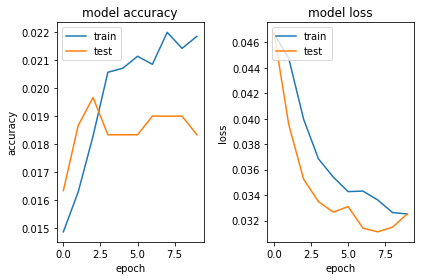

In [12]:
model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(max_sequence_len, 5)))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 5, activation='relu'))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mse',
              optimizer='rmsprop',
              metrics=['accuracy'])
print(model.summary())
# Fit the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=10,verbose=1,
                    validation_data=(X_test, y_test)) #callbacks=[checkpointer]

# evaluate the model
score = max(history.history['val_acc'])
print("%s: %.2f%%" % (model.metrics_names[1], score*100))
plt = plot_results(history.history)
plt.show()